## Vogelscraper - A bird species scraper in a jupyter notebook
This notebook scrapes the Dutch birding site waarneming.nl for bird photos and metadata

Potential improvements: 
* Refactoring the bird_scraper call to be more modular
* being able to retro-actively prune entries if the license does not allow for use 
* Enabling multiprocessing (bit of a moot point, since I deliberately space out requests to be 1 second in between)
* Use flickr data (so essentially scrape flickr or their API)
* Include metadata in the dataset.

## Goal:
* Collect photos of birds, transform them into a uniform shape for training data and store both the raw and processed versions along with some metadata

## See also:
**vogelmodel.ipynb**: A notebook with two CNN models that use this data set. 

## Author
Jeffrey Luppes - jeffluppes@gmail.com

In [30]:
import requests
from bs4 import BeautifulSoup
import shutil
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join
import random
import cv2
import numpy as np
import pandas as pd
import time
import json
import multiprocessing as mp

#settings for folders
RAWFOLDER = 'data/raw'
PROCESSEDFOLDER = 'data/edited'

# how many images to retrieve per species
MAXIMAGES = 10000

# the number of images returned per page (needed for pagination)
IMAGESPERPAGE = 24

# unfortunately, there are many species that we cannot directly query for - just try querying for 'kwikstaart'!
# there are 34 species... which one is relevant for our model?  Futhermore, they're all returned in alphabetical
# format. It would have been more elegant to query for it, but alas, I did that in advance
species = [{
    'name': 'pimpelmees',
    'id': '161'
}, {
    'name': 'koolmees',
    'id': '140'
}, {
    'name': 'staartmees',
    'id': '181'
}, {
    'name': 'kuifmees',
    'id': '145'
}, {
    'name': 'vink',
    'id': '193'
}, {
    'name': 'merel',
    'id': '150'
}, {
    'name': 'spreeuw',
    'id': '180'
}, {
    'name': 'ringmus',
    'id': '166'
}, {
    'name': 'huismus',
    'id': '122'
}, {
    'name': 'geelgors',
    'id': '55'
}, {
    'name': 'groenling',
    'id': '261771'
}, {
    'name': 'heggenmus',
    'id': '118'
}, {
    'name': 'boomkruiper',
    'id': '71'
}, {
    'name': 'boomklever',
    'id': '70'
}, {
    'name': 'roodborstje',
    'id': '168'
}, {
    'name': 'grotebontespecht',
    'id': '109'
}, {
    'name': 'ekster',
    'id': '87'
}, {
    'name': 'putter',
    'id': '162'
},{
    'name': 'winterkoning',
    'id': '199'
},{
    'name': 'zanglijster',
    'id': '204'
},{
    'name': 'houtduif',
    'id': '120'
},{
    'name': 'turksetortel',
    'id': '191'
},{
    'name': 'holenduif',
    'id': '119'
},{
    'name': 'wittekwikstaart',
    'id': '202'
},{
    'name': 'groenespecht',
    'id': '40'
},{
    'name': 'vlaamsegaai',
    'id': '92'
},{
    'name': 'keep',
    'id': '127'
},{
    'name': 'koperwiek',
    'id': '141'
},{
    'name': 'kramsvogel',
    'id': '143'
},{
    'name': 'wielewaal',
    'id': '350'
}]

# CC-BY-NC-ND forbids use as training data (although thats an open debate)
# Additionally, the all rights reserved license seems good to not infringe upon
# Attribution can be done by logging which files are used
ALLOWED_LICENCES = ['CC-BY-NC', 'CC-BY', '-', 'CC-BY-NC-SA']

In [4]:
print('There are {} birds on the scraping list.'.format(len(species)))

There are 30 birds on the scraping list.


In [5]:
def get_and_store_image(url: str, path: str):
    '''Obtain an image fm the world wide web and store it in the path specified'''
    response = requests.get(url, stream=True)
    with open(path, 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response  
    
def center_image(img):
    '''Convenience function to return a centered image'''
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

In [ ]:
def show_random_img_from_folder(folder: str):
    '''Show a random image from the given folder'''
    
    filelist = [f for f in listdir(folder) if isfile(join(folder, f))]
    imglocation = random.choice(filelist)
    
    img=mpimg.imread(folder+'/'+imglocation)
    print(imglocation)
    imgplot = plt.imshow(img)
    plt.show()

In [7]:
def convert_and_store_img(inputpath: str, outputpath: str):
    '''Converts an image and resizes it, stores it to disk (ssd in this case)'''
    
    # try-catch is necessary here because: 
    # a) images might be really small for some reason
    # b) images might be served with a 0-dimension from waarneming.nl (e.g. 512x0) possibly corrupted
    #    during upload / download
    # bit of an antipattern for sure.
    try:
        img = cv2.imread(inputpath)
        
        #calculate tile size
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering + actual resizing
        img = center_image(cv2.resize(img, dsize=tile_size))

        #output should be 224*224px for a quick vggnet16
        img = img[16:240, 16:240]

        cv2.imwrite(outputpath, img)
        
    except:
        print(inputpath)
        pass

In [8]:
def get_photoid_list(species: str) -> list:
    '''Convenience function to return a list of (already-scraped) photo ids for a given species'''
    ids = []
    for r, d, f in os.walk('data/raw/'+species):
        for file in f:
            ids.append(file.split('.')[0])   
    
    return ids

In [31]:
def bird_scraper(species: str, identifier: str):
    '''TODO refactor this at some point. Code has in-line comments for doc'''
    photolinks = []
    
    timeframes = ['2019-02-20&before_date=2020-02-20',
        '2018-02-20&before_date=2019-02-20', 
        '2017-02-20&before_date=2018-02-20',
        '2016-02-20&before_date=2017-02-20',
        '2015-02-20&before_date=2016-02-20',
        '2014-02-20&before_date=2015-02-20',
        '2013-02-20&before_date|=2014-02-20']
    
    time_index = 0
    
    # pagination of the photo gallery starts at 1 and not 0.
    # I also suspect that the gallery is limited to the last year if querying for large time frames.
    
    while len(photolinks)<MAXIMAGES and time_index <= len(timeframes)-1:
        # stop condition: if we've reached the end of the time frames or the max links we wanted to crawl
        
        print('So far, the search for {} has returned {} photos'.format(species, len(photolinks)))
        results = True
        
        while results:
            for i in range(1,100):
                #pause for one second out of courtesy
                time.sleep(1)
                
                # construct the url
                URL = 'https://waarneming.nl/species/'+identifier+'/photos/?after_date='+timeframes[time_index]+'&page='+str(i)

                # fetch the url and content
                page = requests.get(URL)
                soup = BeautifulSoup(page.content, 'html.parser')
                tags=soup.findAll('img',{"class":"app-ratio-box-image"})
                #print('found {} image-links!'.format(len(tags)))
                
                if len(tags) == 0:
                    results = False
                    time_index += 1
                    break
                    
                photolinks += tags


    
    #Show a count of how many we've found
    print('Found {} photos for {}.'.format(len(photolinks), species))
    
    #make folders if they don't yet exist
    if not os.path.exists(RAWFOLDER+'/'+species):
        os.makedirs(RAWFOLDER+'/'+species)

    if not os.path.exists(PROCESSEDFOLDER+'/'+species):
        os.makedirs(PROCESSEDFOLDER+'/'+species)
        
    # get the photoids we already have scraped from - the links change
    # (seems to be some kind of load balancing for storage)
    photoids = get_photoid_list(species)
    new_photos = 0
    
    metadata = []
    # download photos and store them in their new home - the folders we just made
    for link in photolinks:
        
        #url without gibberish
        url = link['src'].split('?w')[0]
        #obtain filename from url
        filename = url.split('/')[5]
        
        #check if we have encountered this photo before- will be substantially slower with large n
        if filename.split('.')[0] not in photoids: 
            
            # we have a new photo, so lets check the metadata first
            meta = get_metadata(filename.split('.')[0])
            
            if meta:
                #print(meta['Licentie'])
                meta['photoid'] = filename
                metadata.append(meta)
                
                if meta['Licentie'] in ALLOWED_LICENCES:
                    path = RAWFOLDER+'/'+species+'/'+filename
                    get_and_store_image(url, path)

                    #also resize the image and store them seperately
                    outputpath = PROCESSEDFOLDER+'/'+species+'/'+filename.split('.')[0]+'.png'

                    convert_and_store_img(path, outputpath)
                    new_photos += 1
                    
                    #pause for one second out of courtesy
                    time.sleep(1)

    print('Found {} new photos of {}'.format(new_photos, species))
    
    #store metadata to flat file
    store_meta(species, metadata)

In [32]:
def store_meta(species: str, meta: list):
    '''Store metadata to file for later use/verification'''
    
    with open(species+'.txt', 'a+') as f:
        for item in meta:
            
            #ignore male/female symbols with the ignore flag
            decoded_item=item.decode('utf-8', 'ignore')
            
            f.write("%s\n" % decoded_item)

In [33]:
def get_metadata(photoid=24691898) -> dict:
    '''Given a photo-id, return metadata in a dict'''
    
    url = 'https://waarneming.nl/photos/'+str(photoid)
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    tags=soup.find('table',{"class":"table app-content-section"})
    meta =  {}
    
    if tags:
        # find all table rows
        rows = tags.find_all('tr')
        values = []
        keys = []
        # get the table content and return as two lists
        for row in rows:
            # actual content is listed in the <td>, while <th> holds the titles. 
            descriptions = row.find_all('th')
            cols = row.find_all('td')
            for idx, ele in enumerate(descriptions):
                keys.append(ele.text.strip())
                values.append(cols[idx].text.strip())

        #create a dict out of the data we fetched
        meta = dict(zip(keys, values))  

    return meta

In [34]:
#check if the metadata call returns the right stuff
get_metadata()

{'Type': 'Foto',
 'Soort': 'Pestvogel Bombycilla garrulus',
 'Levensstadium': 'onbekend',
 'Geslacht': 'onbekend',
 'Datum': '2020-01-25',
 'Gebruiker': 'Luuk Punt',
 'Locatie': 'Almere - Noorderplassen - Woonwijk (oud) (FL)',
 'Validatiestatus': 'goedgekeurd (automatische validatie)',
 'Licentie': 'CC-BY-NC-ND',
 'Views': '99',
 'Likes': '0'}

In [ ]:
# small tester to see if any of this looks good
bird_scraper('groenling', '261771')
show_random_img_from_folder(RAWFOLDER+'/groenling')

So far, the search for groenling has returned 0 photos


Found 3984 photos for huismus.
Found 0 new photos of huismus
huismus:


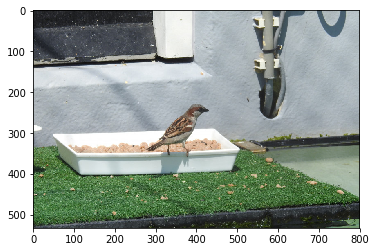

Found 3984 photos for geelgors.
Found 234 new photos of geelgors
geelgors:


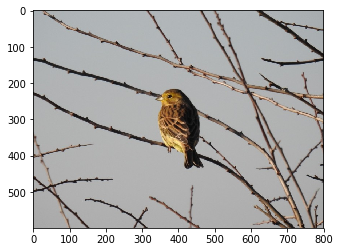

Found 93 photos for groenling.
Found 0 new photos of groenling
groenling:


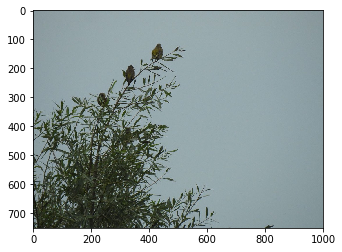

Found 3984 photos for heggenmus.
Found 1280 new photos of heggenmus
heggenmus:


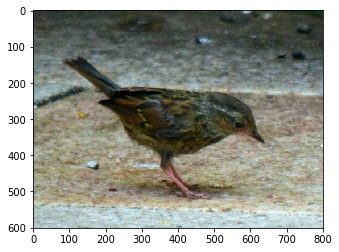

Found 3984 photos for boomkruiper.
Found 1304 new photos of boomkruiper
boomkruiper:


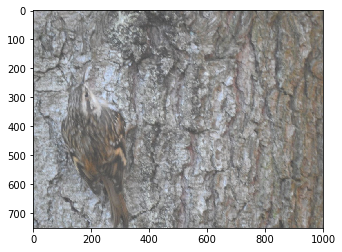

Found 3984 photos for boomklever.
Found 1527 new photos of boomklever
boomklever:


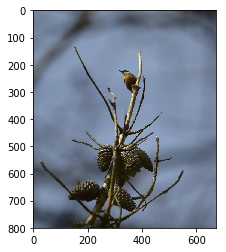

Found 3984 photos for roodborstje.


In [ ]:
# all right, we're good to go!
for s in species:
    bird_scraper(s['name'], s['id'])
    
    # show a random photo to brighten the day
    print(str(s['name'])+':')
    show_random_img_from_folder(RAWFOLDER+'/'+s['name'])

In [118]:
#construct lists with training data 
labels = []
filenames = []

# r=root, d=directories, f = files
for r, d, f in os.walk('data/edited'):
    for file in f:

        if ".png" in file:
            labels.append(r.split('/')[2])
            filenames.append(os.path.join(r, file))
            pass

In [121]:
df = pd.DataFrame({
    'filename': filenames,
    'label': labels
})

In [122]:
df.head()

,filename,label
0,data/edited/staartmees/23917770.png,staartmees
1,data/edited/staartmees/24551767.png,staartmees
2,data/edited/staartmees/21872269.png,staartmees
3,data/edited/staartmees/24209707.png,staartmees
4,data/edited/staartmees/24567381.png,staartmees


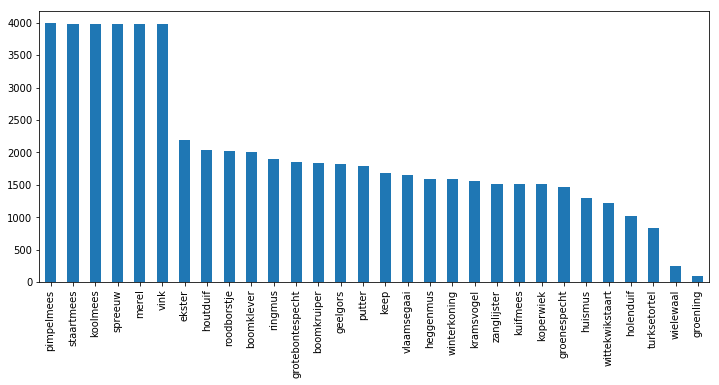

In [131]:
plt.figure(figsize=(12,5))
df['label'].value_counts().plot.bar()

In [125]:
print('In total there are {} photos for training across {} species'.format(len(df), len(df['label'].unique())))

In total there are 60149 photos for training across 30 species


In [132]:
#show how much free space is left - considering this runs inside a google cloud VM
!df

Filesystem     1K-blocks     Used Available Use% Mounted on
udev             7691184        0   7691184   0% /dev
tmpfs            1540472    49096   1491376   4% /run
/dev/sda1      103144356 39695588  59133672  41% /
tmpfs            7702344        4   7702340   1% /dev/shm
tmpfs               5120        0      5120   0% /run/lock
tmpfs            7702344        0   7702344   0% /sys/fs/cgroup


In [127]:
#store to disk for later use
df.to_csv('data/waarneming_bird_data_set.csv', index=False)